Explored more bandpower features. 

Tried combining log bandpower, absolute bandpower and relative bandpower. Thought this could boost performance. Wanted to test windowing, but that is really computationally expensive. Spoiler, it didnt really.

I knew this would blow up the number of features, but still thought something like a random forest could handle this extra features. it did not. Moving onto scalograms.

In [24]:
import pandas as pd
import scipy.io
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import welch
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


# Creating the Like DF

In [2]:
path = "../data/behavioralRatings.mat"
with h5py.File(path, "r") as f:
    print("HDF5 keys:", list(f.keys()))

HDF5 keys: ['behavioralRatings']


In [3]:
with h5py.File(path, "r") as f:
    br = f["behavioralRatings"]
    print("Type:", type(br))
    print("Shape:", br.shape)
    print("Dtype:", br.dtype)

Type: <class 'h5py._hl.dataset.Dataset'>
Shape: (2, 10, 20)
Dtype: float64


In [4]:
with h5py.File(path, "r") as f:
    br = f["behavioralRatings"][:]   # turn into NumPy array, shape (2, 10, 20)

In [5]:
# (2, 10, 20) to (20, 10, 2) in order to turn into same structure as matlab 
ratings = np.transpose(br, (2, 1, 0))

print(ratings.shape)

(20, 10, 2)


In [6]:
enjoyment = ratings[:, :, 1] 

In [7]:
participants = np.arange(1, 21)
songs = np.arange(1, 11)

like_df = pd.DataFrame(enjoyment,
                      index=participants,
                      columns=[f"song_{s}" for s in songs]).rename_axis("subject").reset_index()

like_df

,subject,song_1,song_2,song_3,song_4,song_5,song_6,song_7,song_8,song_9,song_10
0,1,8.0,8.0,5.0,5.0,9.0,7.0,6.0,7.0,5.0,5.0
1,2,8.0,8.0,7.0,5.0,3.0,7.0,5.0,5.0,4.0,4.0
2,3,8.0,7.0,8.0,6.0,8.0,7.0,7.0,8.0,7.0,6.0
3,4,8.0,7.0,2.0,7.0,9.0,6.0,7.0,7.0,5.0,7.0
4,5,6.0,8.0,6.0,5.0,7.0,7.0,8.0,7.0,7.0,3.0
5,6,4.0,5.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0,1.0
6,7,6.0,2.0,2.0,5.0,3.0,7.0,3.0,5.0,3.0,2.0
7,8,5.0,8.0,3.0,7.0,5.0,6.0,6.0,6.0,7.0,4.0
8,9,7.0,5.0,6.0,5.0,6.0,5.0,4.0,6.0,3.0,2.0
9,10,5.0,4.0,2.0,7.0,5.0,6.0,4.0,7.0,3.0,1.0


# Feature Creation

In [8]:
# Basically mapping freq to names/categories
BANDS = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 12),
    "beta": (12, 30),
    "gamma_low": (30, 45),
}

In [9]:
np.random.seed(42)

In [10]:
def calculate_bandpower(f, psd, fmin, fmax):
    idx = (f >= fmin) & (f <= fmax)
    return np.trapezoid(psd[idx], f[idx])

In [ ]:
all_X = []
all_y = []
participant_ids = []
song_ids = []

for song in range(21, 31):

    load_mat_file = loadmat(f"../data/cleaned_eeg/song{song}_Imputed.mat")
    data = load_mat_file[f"data{song}"] # (channels=125, time, participants)
    fs = float(load_mat_file["fs"].squeeze())

    channels, time, n_participants = data.shape

    song_idx = song - 20
    song_label = like_df[f"song_{song_idx}"].to_numpy()

    for participant in range(n_participants):
        eeg_participant = data[:, :, participant]  # (channels, time)

        # ABSOLUTE BANDPOWER!!
        full_abs_bandpower = []

        for ch in range(channels):
            sig = eeg_participant[ch, :]
            f_full, psd_full = welch(
                sig,
                fs=fs,
                nperseg=2 * int(fs)
            )

            for fmin, fmax in BANDS.values():
                bp = calculate_bandpower(f_full, psd_full, fmin, fmax)
                full_abs_bandpower.append(bp)

        full_abs_bandpower = np.array(full_abs_bandpower)  # (channels * n_bands,)

        # RELATIVE BANDPOWER (per channel)
        full_rel_bandpower = []
        n_bands = len(BANDS)

        full_abs_matrix = full_abs_bandpower.reshape(channels, n_bands)

        for ch in range(channels):
            total_power = full_abs_matrix[ch].sum() + .00000000000000001
            rel_powers = full_abs_matrix[ch] / total_power
            full_rel_bandpower.extend(rel_powers)

        full_rel_bandpower = np.array(full_rel_bandpower)  # (channels x n_bands,)

        # LOG BANDPOWER
        full_log_bandpower = np.log10(full_abs_bandpower + .0000000000000001)  # (channels x n_bands,)

        # combine features -> [absolute, relative, log-absolute]
        feature_vec = np.concatenate([
            full_abs_bandpower,
            full_rel_bandpower,
            full_log_bandpower
        ])

        all_X.append(feature_vec)
        all_y.append(1 if song_label[participant] >= 6 else 0)
        participant_ids.append(participant)
        song_ids.append(song_idx)

# Convert lists to arrays
X_all = np.vstack(all_X)
y_all = np.array(all_y)
participant_ids = np.array(participant_ids)
song_ids = np.array(song_ids)

print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)


X_all shape: (200, 1875)
y_all shape: (200,)


In [12]:
pd.DataFrame(X_all)

,0,1,2,3,4,5,6,7,8,9,...,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874
0,5.437154,3.295769,2.291528,3.901327,1.134805,4.739319,2.946570,2.193457,7.466447,5.888619,...,0.533776,0.590708,0.351696,0.670366,-0.092422,0.621949,0.751444,0.606980,0.855188,-0.121695
1,6.802102,2.209015,6.177883,2.973930,0.719417,7.997379,2.289363,7.396735,3.644470,0.949761,...,0.833698,0.342209,0.798735,0.474534,-0.358329,0.764603,0.306948,0.732067,0.456729,-0.532869
2,7.803644,3.607513,5.169091,2.381346,0.767014,32.320292,6.439324,6.739752,6.392207,3.306073,...,0.756495,0.444941,0.606594,0.282850,-0.382810,0.581887,0.701730,0.814113,0.309131,-0.595847
3,12.926713,5.191892,2.780866,3.294347,1.304612,13.052549,8.681723,3.477780,4.630973,1.674099,...,0.917731,0.762848,0.297982,0.375505,-0.152520,0.981974,0.834027,0.653438,0.462594,-0.248389
4,11.682139,4.208124,4.340531,5.057867,1.501342,26.018133,7.611409,7.664269,9.744701,3.542585,...,1.078836,0.685927,0.544265,0.818167,0.302669,0.959196,0.666225,0.569900,0.610659,-0.207420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,9.161990,3.246197,1.170821,1.983636,0.785976,6.466018,2.356428,0.908777,1.341314,0.556842,...,0.722118,0.373444,-0.052891,0.131516,-0.337811,0.684117,0.551660,0.033654,0.125793,-0.488601
196,11.361508,5.616728,9.461826,2.736033,0.907838,8.636768,5.996460,12.358313,3.628967,1.128384,...,0.798728,0.835067,1.071288,0.579723,-0.062425,0.890615,1.048405,1.262889,0.672654,-0.202523
197,12.891483,3.990714,2.202423,3.169409,1.981254,8.765260,2.735044,1.756600,6.674329,4.085634,...,0.642207,0.274625,0.051561,0.318407,0.073765,0.691856,0.321364,0.111347,0.213866,-0.034468
198,12.343607,6.736856,7.796902,7.058343,2.654313,12.927676,5.909995,7.705911,7.626168,1.666947,...,0.641523,0.536660,0.789501,0.678763,-0.214273,0.651204,0.613554,0.759610,0.493334,-0.325397


# Loading in Cleaned EEG data

In [13]:
np.random.seed(42)

In [14]:
# all_X = []
# all_y = []
# participant_ids = []
# song_ids = []

# # they had weird mappings in the study, these numbers correspond to file names
# # looping through each song
# for song in range(21, 31):
#     # loads in the file
#     load_mat_file = loadmat(f"../data/cleaned_eeg/song{song}_Imputed.mat")
#     # gets the current song
#     data = load_mat_file[f"data{song}"]

#     fs = float(load_mat_file["fs"].squeeze())

#     channels, time, participants = data.shape

#     # converting werid mappings to start at 1
#     song_idx = song - 20
#     song_label = like_df[f"song_{song_idx}"].to_numpy()

#     # loop through each participant
#     for participant in range(participants):
#         # get eeg data for given participant for the given song
#         eeg_participant = data[:, :, participant]

#         # this chunk just gets the band power for each participant for given song
#         feature_list = []
#         for channel in range(channels):
#             f, psd = welch(eeg_participant[channel, :], fs = fs, nperseg = 2 * int(fs))
#             for fmin, fmax in BANDS.values():
#                 band_power = calculate_bandpower(f, psd, fmin, fmax)
#                 feature_list.append(band_power)

#         feature_vec = np.log10(np.array(feature_list) + .000000000000000000001)
#         all_X.append(feature_vec)

#         # basically liked if score above 6, no like below 6
#         all_y.append(1 if song_label[participant] >= 6 else 0)
#         participant_ids.append(participant)
#         song_ids.append(song_idx)

# # Convert to usable format
# X_all = np.vstack(all_X)
# y_all = np.array(all_y)

# participant_ids = np.array(participant_ids)
# song_ids = np.array(song_ids)


In [15]:
scaler = StandardScaler()
logo = LeaveOneGroupOut()
X_scaled = scaler.fit_transform(X_all)
logo

LeaveOneGroupOut()

In [16]:
logistic_reg_initial = LogisticRegression(max_iter = 2000, random_state = 42)

## Metrics for Logistic Reg

In [17]:
accuracies = []
precisions = []
recalls = []
# conf_matrix_folds = []

# collecting across all folds bc my prec recall kinda weird with some classes having none per fold
all_folds_y_true = []
all_folds_y_pred = []

for train_idx, test_idx in logo.split(X_scaled, y_all, participant_ids):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]

    logistic_reg_initial.fit(X_train, y_train)
    y_pred = logistic_reg_initial.predict(X_test)
    y_prob = logistic_reg_initial.predict_proba(X_test)[:, 1]

    accuracies.append(accuracy_score(y_test, y_pred))

    all_folds_y_true.extend(y_test)
    all_folds_y_pred.extend(y_pred)

    # cm = confusion_matrix(y_test, y_pred, labels = [0,1])
    # conf_matrix_folds.append(cm)
    
    # precisions.append(precision_score(y_test, y_pred, pos_label=1, zero_division = 0))
    # recalls.append(recall_score(y_test, y_pred, pos_label = 1, zero_division=0))

    prec, rec, f1, support = precision_recall_fscore_support(
        y_test,
        y_pred,
        labels = [0,1],
        average = None,
        zero_division = 0
    )

    precisions.append(prec)
    recalls.append(rec)

all_folds_y_true = np.array(all_folds_y_true)
all_folds_y_pred = np.array(all_folds_y_pred)

prec, rec, f1, support = precision_recall_fscore_support(
    all_folds_y_true,
    all_folds_y_pred,
    labels = [0,1],
    average = None,
    zero_division = 0
)

# print("Precision across all folds: ", np.mean(precisions))
# print("Recall across all folds: ", np.mean(recalls))

precisions = np.array(precisions)
recalls = np.array(recalls)

mean_prec_class0, mean_prec_class1 = precisions.mean(axis = 0)
mean_recall_class0, mean_recall_class1 = recalls.mean(axis = 0)

print("Metrics from aggregation across folds")
print("Acurracy across all folds: ", np.mean(accuracies))

print("Precision for Class 0: ", mean_prec_class0)
print("Precision for Class 1: ", mean_prec_class1)

print("Recall for Class 0: ", mean_recall_class0)
print("Recall for Class 1: ", mean_recall_class1)

print("------------------------------------")
print("Computing Precision Recall whole data set (not per fold)")

print("Precision for class 0: ", prec[0])
print("Precision for class 1: ", prec[1])

print("Recall for class 0: ", rec[0])
print("Recall for class 1: ", rec[1])

Metrics from aggregation across folds
Acurracy across all folds:  0.51
Precision for Class 0:  0.3148015873015873
Precision for Class 1:  0.43154761904761907
Recall for Class 0:  0.4370238095238094
Recall for Class 1:  0.5068055555555556
------------------------------------
Computing Precision Recall whole data set (not per fold)
Precision for class 0:  0.4631578947368421
Precision for class 1:  0.5523809523809524
Recall for class 0:  0.4835164835164835
Recall for class 1:  0.5321100917431193


In [ ]:
# did not tune, could be future works (kinda mannually tuned but not really efficient)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=10,
    max_features=0.2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

In [26]:
accuracies = []
precisions = []
recalls = []
# conf_matrix_folds = []

# collecting across all folds bc my prec recall kinda weird with some classes having none per fold
all_folds_y_true = []
all_folds_y_pred = []

for train_idx, test_idx in logo.split(X_scaled, y_all, participant_ids):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]

    accuracies.append(accuracy_score(y_test, y_pred))

    all_folds_y_true.extend(y_test)
    all_folds_y_pred.extend(y_pred)

    # cm = confusion_matrix(y_test, y_pred, labels = [0,1])
    # conf_matrix_folds.append(cm)
    
    # precisions.append(precision_score(y_test, y_pred, pos_label=1, zero_division = 0))
    # recalls.append(recall_score(y_test, y_pred, pos_label = 1, zero_division=0))

    prec, rec, f1, support = precision_recall_fscore_support(
        y_test,
        y_pred,
        labels = [0,1],
        average = None,
        zero_division = 0
    )

    precisions.append(prec)
    recalls.append(rec)

all_folds_y_true = np.array(all_folds_y_true)
all_folds_y_pred = np.array(all_folds_y_pred)

prec, rec, f1, support = precision_recall_fscore_support(
    all_folds_y_true,
    all_folds_y_pred,
    labels = [0,1],
    average = None,
    zero_division = 0
)

# print("Precision across all folds: ", np.mean(precisions))
# print("Recall across all folds: ", np.mean(recalls))

precisions = np.array(precisions)
recalls = np.array(recalls)

mean_prec_class0, mean_prec_class1 = precisions.mean(axis = 0)
mean_recall_class0, mean_recall_class1 = recalls.mean(axis = 0)

print("Metrics from aggregation across folds")
print("Acurracy across all folds: ", np.mean(accuracies))

print("Precision for Class 0: ", mean_prec_class0)
print("Precision for Class 1: ", mean_prec_class1)

print("Recall for Class 0: ", mean_recall_class0)
print("Recall for Class 1: ", mean_recall_class1)

print("------------------------------------")
print("Computing Precision Recall whole data set (not per fold)")

print("Precision for class 0: ", prec[0])
print("Precision for class 1: ", prec[1])

print("Recall for class 0: ", rec[0])
print("Recall for class 1: ", rec[1])

Metrics from aggregation across folds
Acurracy across all folds:  0.5650000000000001
Precision for Class 0:  0.265515873015873
Precision for Class 1:  0.5849801587301587
Recall for Class 0:  0.3270833333333333
Recall for Class 1:  0.6279761904761905
------------------------------------
Computing Precision Recall whole data set (not per fold)
Precision for class 0:  0.5294117647058824
Precision for class 1:  0.5833333333333334
Recall for class 0:  0.3956043956043956
Recall for class 1:  0.7064220183486238


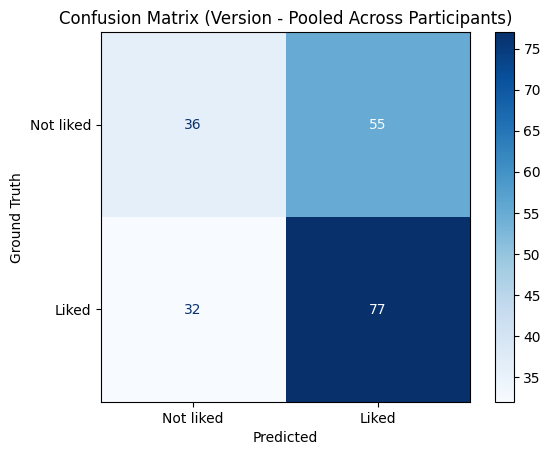

In [27]:
conf_matrix = confusion_matrix(all_folds_y_true, all_folds_y_pred, labels = [0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix = conf_matrix,
    display_labels = ["Not liked", "Liked"]
)

disp.plot(cmap="Blues", values_format = ".0f")
plt.title("Confusion Matrix (Version - Pooled Across Participants)")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.show()

## More Power

## Metrics for Linear SVM

In [ ]:
# didnt tune :(
svm_linear = SVC(
    kernel = "linear",
    C = 1,
    probability = True,
    class_weight = "balanced",
    random_state = 42
)

In [22]:
accuracies = []
precisions = []
recalls = []

# collecting across all folds bc my prec recall kinda weird with some classes having none per fold
all_folds_y_true = []
all_folds_y_pred = []

for train_idx, test_idx in logo.split(X_scaled, y_all, participant_ids):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]

    svm_linear.fit(X_train, y_train)
    y_pred = svm_linear.predict(X_test)
    y_prob = svm_linear.predict_proba(X_test)[:, 1]

    accuracies.append(accuracy_score(y_test, y_pred))

    all_folds_y_true.extend(y_test)
    all_folds_y_pred.extend(y_pred)

    
    # precisions.append(precision_score(y_test, y_pred, pos_label=1, zero_division = 0))
    # recalls.append(recall_score(y_test, y_pred, pos_label = 1, zero_division=0))

    prec, rec, f1, support = precision_recall_fscore_support(
        y_test,
        y_pred,
        labels = [0,1],
        average = None,
        zero_division = 0
    )

    precisions.append(prec)
    recalls.append(rec)

all_folds_y_true = np.array(all_folds_y_true)
all_folds_y_pred = np.array(all_folds_y_pred)

prec, rec, f1, support = precision_recall_fscore_support(
    all_folds_y_true,
    all_folds_y_pred,
    labels = [0,1],
    average = None,
    zero_division = 0
)

# print("Precision across all folds: ", np.mean(precisions))
# print("Recall across all folds: ", np.mean(recalls))

precisions = np.array(precisions)
recalls = np.array(recalls)

mean_prec_class0, mean_prec_class1 = precisions.mean(axis = 0)
mean_recall_class0, mean_recall_class1 = recalls.mean(axis = 0)

print("Metrics from aggregation across folds")
print("Acurracy across all folds: ", np.mean(accuracies))

print("Precision for Class 0: ", mean_prec_class0)
print("Precision for Class 1: ", mean_prec_class1)

print("Recall for Class 0: ", mean_recall_class0)
print("Recall for Class 1: ", mean_recall_class1)

print("------------------------------------")
print("Computing Precision Recall whole data set (not per fold)")

print("Precision for class 0: ", prec[0])
print("Precision for class 1: ", prec[1])

print("Recall for class 0: ", rec[0])
print("Recall for class 1: ", rec[1])

Metrics from aggregation across folds
Acurracy across all folds:  0.5349999999999999
Precision for Class 0:  0.3489682539682539
Precision for Class 1:  0.4416666666666667
Recall for Class 0:  0.4245238095238095
Recall for Class 1:  0.5608333333333333
------------------------------------
Computing Precision Recall whole data set (not per fold)
Precision for class 0:  0.48863636363636365
Precision for class 1:  0.5714285714285714
Recall for class 0:  0.4725274725274725
Recall for class 1:  0.5871559633027523
